#Prediction of Helpfulness

##Import libraries and download data

In [67]:
import os
import json
import gzip
from urllib.request import urlopen
import numpy as np
import pandas as pd
import random
import string
import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
import string
import re
import itertools
from __future__ import division, print_function, absolute_import
from gensim.models import Word2Vec

from nltk.data import find
from sklearn.metrics import roc_curve, auc

import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import seaborn as sns

%load_ext autoreload
%autoreload 2

from IPython.display import display # Allows the use of display() for DataFrames

import warnings
warnings.filterwarnings('ignore')

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

# constants
FIG_SIZE = (14,8)
RAN_STATE = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Kindle_Store_10.json.gz

--2021-08-23 15:29:48--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Kindle_Store_10.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111295907 (106M) [application/x-gzip]
Saving to: ‘reviews_Kindle_Store_10.json.gz’

reviews_Kindle_Stor 100%[===================>] 106.14M  6.52MB/s    in 11s     

2021-08-23 15:30:00 (9.37 MB/s) - ‘reviews_Kindle_Store_10.json.gz’ saved [111295907/111295907]



In [4]:
# load the data
data = []
with gzip.open('reviews_Kindle_Store_10.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
# total length of list, this number equals total number of products
print(len(data))
# first row of the list
print(data[0])

367478
{'reviewerID': 'A33EX8MZYBV0YI', 'asin': 'B000JMLBHU', 'reviewerName': 'alone with books', 'helpful': [0, 0], 'reviewText': 'this was an Ok book, but slow at times, I actually put it down and read something else and then came back, the second part was better, when  other people came into the story', 'overall': 3.0, 'summary': 'the Mysterrous Island', 'unixReviewTime': 1374537600, 'reviewTime': '07 23, 2013'}


##Data Preprocessing

In [5]:
# convert list into pandas dataframe
data_df = pd.DataFrame.from_dict(data)
print(len(data_df))

367478


In [7]:
# select the columns
df = data_df.iloc[:, [5,4,3]]

# split numerator and denominator
df['helpful_numerator'] = df['helpful'].apply(lambda x: x[0])
df['helpful_denominator'] = df['helpful'].apply(lambda x: x[1])

# delete un-needed 'helpful catagory
del df['helpful']

# check if we have any null values
print (df.isnull().sum())

overall                0
reviewText             0
helpful_numerator      0
helpful_denominator    0
dtype: int64


In [8]:
print (df['helpful_numerator'].idxmax(axis=0, skipna=True))
print (df['helpful_denominator'].idxmax(axis=0, skipna=True))

37707
37707


In [9]:
# include reviews that have more than 10 helpfulness data point only
df1 = df[(df.helpful_denominator > 10)].copy()
df1.shape

(6643, 4)

In [19]:
df1

,overall,reviewText,helpful_numerator,helpful_denominator,Helpful
34,5.0,"im shocked to see the reviews for this series,...",14,16,1
35,5.0,i've enjoyed several of ms. d'arc's other book...,18,18,1
49,5.0,belora lives with her mother in an isolated fo...,13,14,1
52,3.0,"reading the reviews before purchasing this, th...",11,12,1
55,4.0,reviewed by ann & posted at under the covers b...,18,18,1
...,...,...,...,...,...
366393,5.0,jonny bell is the only author i read twice.thi...,11,11,1
367291,5.0,"come back is the second book in the dirty, dar...",12,12,1
367417,5.0,"i was trusted with this arc, in exchange for a...",9,11,1
367438,5.0,this book was absolutely perfect! second chanc...,14,17,1


In [11]:
# transform Helpfulness into a binary variable with 0.50 ratio
threshold = 0.5
df1.loc[:, 'Helpful'] = np.where(df1.loc[:, 'helpful_numerator'] \
                                 / df1.loc[:, 'helpful_denominator'] > threshold, 1, 0)
df1.head(3)

,overall,reviewText,helpful_numerator,helpful_denominator,Helpful
34,5.0,"Im shocked to see the reviews for this series,...",14,16,1
35,5.0,I've enjoyed several of Ms. D'arc's other book...,18,18,1
49,5.0,Belora lives with her mother in an isolated fo...,13,14,1


In [12]:
# check the balance
print ('Count:')
display(df1.groupby('Helpful').count())

Count:


,overall,reviewText,helpful_numerator,helpful_denominator
Helpful,,,,
0,439,439,439,439
1,6204,6204,6204,6204


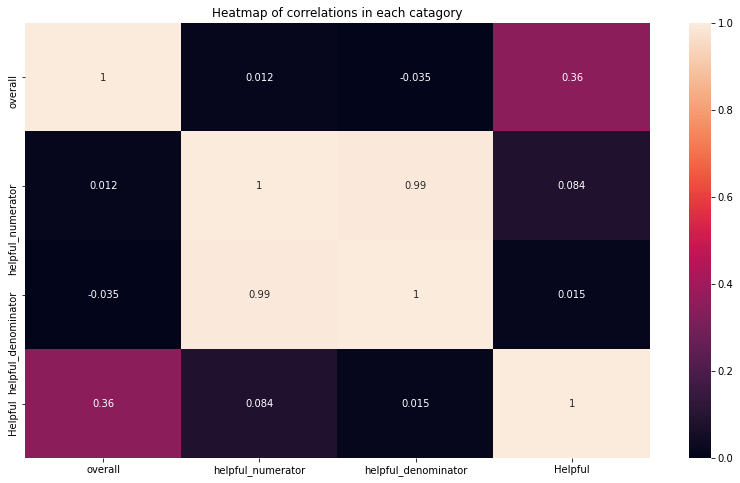

In [13]:
# visualize correlation of the data
correlations = df1.corr()
plt.figure(figsize = FIG_SIZE)
plt.title("Heatmap of correlations in each catagory")
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)

In [14]:
# convert text to lowercase
df1.loc[:, 'reviewText'] = df1['reviewText'].str.lower()

def remove_punctuation(text):
    return text.translate(string.punctuation.translate('"'))

df1['reviewText']=df1['reviewText'].apply( lambda x: remove_punctuation(x))
df1['reviewText'].head(4)

34    im shocked to see the reviews for this series,...
35    i've enjoyed several of ms. d'arc's other book...
49    belora lives with her mother in an isolated fo...
52    reading the reviews before purchasing this, th...
Name: reviewText, dtype: object

In [15]:
# tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

# create a stemmer
stemmer = SnowballStemmer("english")


# define our own tokenizing function that we will pass into the TFIDFVectorizer. We will also stem the words here.
def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems

# loads pickle if exists, extracts and pickles if it doesn't
if os.path.exists('features.pickle'):
    print ('Pickled file already present, loading...')
    features = pickle.load( open( "features.pickle", "rb" ) )
    print ('Pickle file loaded.')
else:
    # define the vectorizer
    vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), min_df = 0.01)
    # fit the vectorizers to the data.
    features = vectorizer.fit_transform(df1['reviewText'])
features

<6643x1350 sparse matrix of type '<class 'numpy.float64'>'
	with 356952 stored elements in Compressed Sparse Row format>

##Train and Test the Model

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
import time
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # start the clock, train the classifier, then stop the clock
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    
    # print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on roc_auc score. '''
    
    # start the clock, make predictions, then stop the clock
    start = time.time()
    probas = clf.predict_proba(features)
    end = time.time()
    
    # print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    return roc_auc_score(target.values, probas[:,1].T)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on roc_auc score. '''
    
    # indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, X_train.shape[0]))
    
    # train the classifier
    train_classifier(clf, X_train, y_train)
    
    # print the results of prediction for both training and testing
    print ("ROC_AUC score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print ("ROC_AUC score for test set: {:.4f}.\n".format(predict_labels(clf, X_test, y_test)))
    
def clf_test_roc_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    probas = probas =clf.predict_proba(X_test)
    return roc_auc_score(y_test, probas[:,1].T)

In [18]:
# import the supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


# initialize the models using a random state were applicable.
clf_list = [GaussianNB(), 
            AdaBoostClassifier(random_state = RAN_STATE), 
            RandomForestClassifier(random_state = RAN_STATE), 
            LogisticRegression(random_state = RAN_STATE),
            DecisionTreeClassifier(random_state = RAN_STATE)]
x_tr = X_train.toarray()
x_te = X_test.toarray()


# set up the training set sizes 
train_feature_list = [x_tr[0:1000],x_tr[0:2500],x_tr]
train_target_list = [y_train[0:1000], y_train[0:2500], y_train]


# execute the 'train_predict' function for each of the classifiers and each training set size
for clf in clf_list:
    for a, b in zip(train_feature_list, train_target_list):
        train_predict(clf, a, b, x_te, y_test)

Training a GaussianNB using a training set size of 1000. . .
Trained model in 0.0193 seconds
Made predictions in 0.0192 seconds.
ROC_AUC score for training set: 0.9860.
Made predictions in 0.0264 seconds.
ROC_AUC score for test set: 0.5571.

Training a GaussianNB using a training set size of 2500. . .
Trained model in 0.0487 seconds
Made predictions in 0.0434 seconds.
ROC_AUC score for training set: 0.9417.
Made predictions in 0.0226 seconds.
ROC_AUC score for test set: 0.6287.

Training a GaussianNB using a training set size of 5314. . .
Trained model in 0.1084 seconds
Made predictions in 0.0950 seconds.
ROC_AUC score for training set: 0.9239.
Made predictions in 0.0234 seconds.
ROC_AUC score for test set: 0.7184.

Training a AdaBoostClassifier using a training set size of 1000. . .
Trained model in 1.0379 seconds
Made predictions in 0.1561 seconds.
ROC_AUC score for training set: 0.9950.
Made predictions in 0.2137 seconds.
ROC_AUC score for test set: 0.6947.

Training a AdaBoostClass

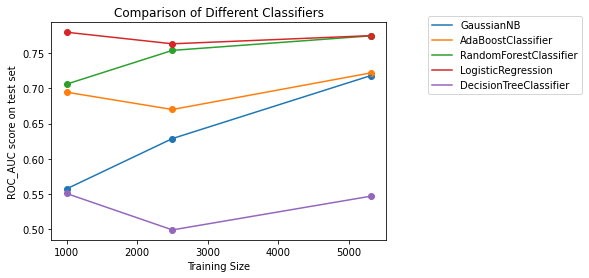

<Figure size 1008x576 with 0 Axes>

In [20]:
# visualize all of the classifiers                                                               
for clf in clf_list:
    x_graph = []
    y_graph = []
    for a, b in zip(train_feature_list, train_target_list):
        y_graph.append(clf_test_roc_score(clf, a, b, x_te, y_test))
        x_graph.append(len(a))
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('ROC_AUC score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure(figsize=FIG_SIZE)             
plt.show()

##Add Overall Rating Feature

In [29]:
# add Score column to features
import scipy as scipy
from six.moves import cPickle as pickle

# features = pickle.load( open( "features.pickle", "rb" ) )
overall = np.array(list(df1.overall))
overall = overall.reshape(features.shape[0], 1)

features2 = scipy.sparse.hstack((features,scipy.sparse.csr_matrix(overall)))

features2 = scipy.sparse.csr_matrix(features2)
features2

<6643x1351 sparse matrix of type '<class 'numpy.float64'>'
	with 363595 stored elements in Compressed Sparse Row format>

In [30]:
X_train2, X_test2, y_train, y_test = train_test_split(features2, df1['Helpful'], test_size=0.2, random_state=RAN_STATE)

In [31]:
from sklearn import model_selection
# make the grid search object
gs2 = model_selection.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**i for i in range(-5,5)], 'class_weight': [None, 'balanced']},
    cv=model_selection.StratifiedKFold(n_splits=5),
    scoring='roc_auc'
)

# fit the grid search object to our new dataset
print ('Fitting grid search...')
gs2.fit(X_train2, y_train)
print ("Grid search fitted.")

Fitting grid search...
Grid search fitted.


In [32]:
# print the grid search scores.
print (gs2.best_estimator_)
gs2.best_params_

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


{'C': 1, 'class_weight': 'balanced'}

ROC_AUC Score: 0.8561574208539064


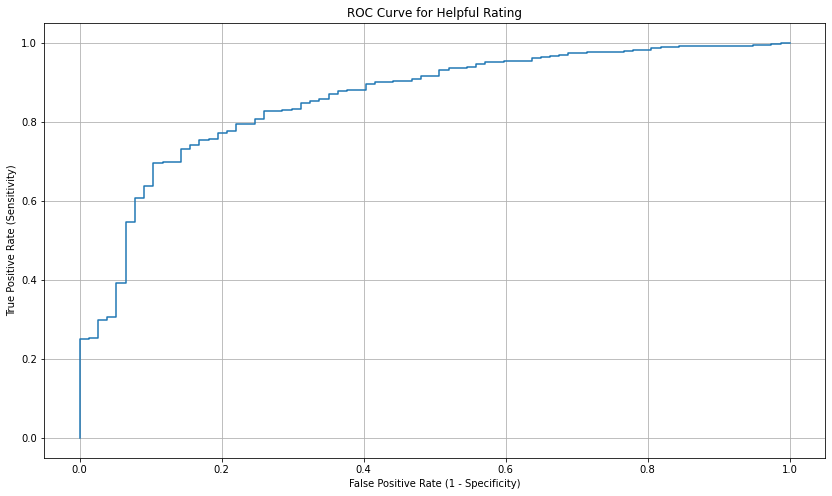

In [33]:
clf2 = gs2.best_estimator_
probas =clf2.predict_proba(X_test2)
plt.figure(figsize = FIG_SIZE)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show

# ROC/AUC score
print ('ROC_AUC Score:',roc_auc_score(y_test, probas[:,1].T))

In [34]:
random_numbers = range(1,101)
tot = 0.0
for seed in random_numbers:
    clf3 = LogisticRegression(random_state=seed)
    clf3.fit(X_train2, y_train)
    probas =clf3.predict_proba(X_test2)
    tot += roc_auc_score(y_test, probas[:,1].T)
    
print ('Average ROC_AUC Score for 1-100 random_state: {:.4f}'.format(tot/100))


Average ROC_AUC Score for 1-100 random_state: 0.8612


##Compare Models with and without Overall Feature

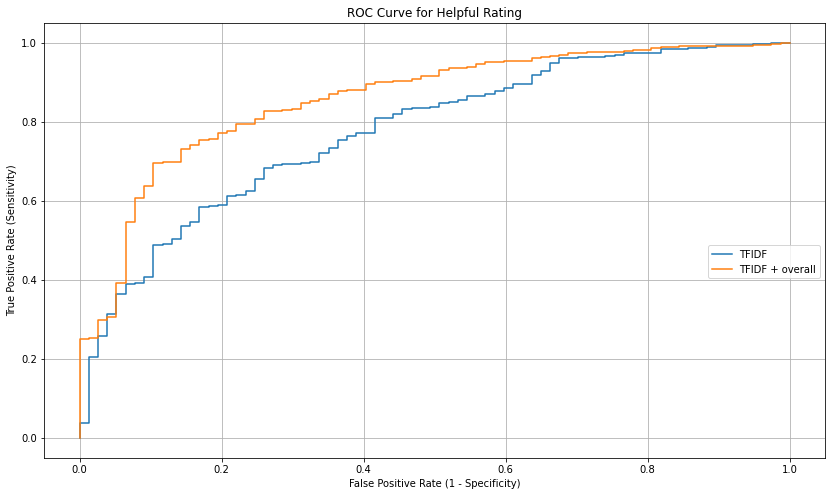

<Figure size 1008x576 with 0 Axes>

In [35]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
probas = clf.predict_proba(X_test)
clf2 = gs2.best_estimator_
probas2 =clf2.predict_proba(X_test2)
plt.figure(figsize = FIG_SIZE)

plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1], label = 'TFIDF')
plt.plot(roc_curve(y_test, probas2[:,1])[0], roc_curve(y_test, probas2[:,1])[1], label = 'TFIDF + overall')
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.legend(bbox_to_anchor=(1.0, .5))
plt.figure(figsize=FIG_SIZE) 
plt.show()

#Predict Helpfulness of Generated Reviews

##Download and Preprocess Generated Reviews

In [36]:
# obtain the generated reviews and convert to array
path_to_file = '/content/drive/MyDrive/Colab Notebooks/edited_words.txt'
example = open(path_to_file, 'rb').read().decode(encoding='utf-8')
example = example.replace('\n', ' ')
ex_str = str(example)
ex_arr = ex_str.split("\"")
df_generated = pd.DataFrame(ex_arr, columns = ['generatedReviewText'])

In [37]:
# convert text to lowercase
df_generated.loc[:, 'generatedReviewText'] = df_generated['generatedReviewText'].str.lower()

def remove_punctuation(text):
    return text.translate(string.punctuation.translate('"'))

df_generated['generatedReviewText']=df_generated['generatedReviewText'].apply( lambda x: remove_punctuation(x))
df_generated['generatedReviewText'].head(4)

0    the book is subtised. until i just made edjort...
1     the book expresses his new turns and makes a ...
2     the books were going to caught up it with a s...
3     the books boyfriends, lucas apart.  i clicked...
Name: generatedReviewText, dtype: object

In [38]:
pred_features = vectorizer.transform(df_generated['generatedReviewText'])
pred_features

<10x1350 sparse matrix of type '<class 'numpy.float64'>'
	with 502 stored elements in Compressed Sparse Row format>

##Use LR Model to Predict Helpfulness

In [45]:
print(clf.predict_proba(pred_features))

[[0.02151569 0.97848431]
 [0.02156721 0.97843279]
 [0.02850151 0.97149849]
 [0.03624393 0.96375607]
 [0.03301399 0.96698601]
 [0.03021557 0.96978443]
 [0.02366331 0.97633669]
 [0.02526955 0.97473045]
 [0.04482887 0.95517113]
 [0.02601805 0.97398195]]


In [47]:
print(clf.predict(pred_features))

[1 1 1 1 1 1 1 1 1 1]


##Add Feature and Make Prediction

In [60]:
df_generated['overall'] = [4.5,4.5,1.5,1.5,1.5,4.5,1.5,1.5,1.5,4.5]

In [64]:
pred_overall = np.array(list(df_generated.overall))
pred_overall = pred_overall.reshape(pred_features.shape[0], 1)

pred_features2 = scipy.sparse.hstack((pred_features,scipy.sparse.csr_matrix(pred_overall)))

pred_features2 = scipy.sparse.csr_matrix(pred_features2)
pred_features2

<10x1351 sparse matrix of type '<class 'numpy.float64'>'
	with 512 stored elements in Compressed Sparse Row format>

In [65]:
print(clf2.predict_proba(pred_features2))

[[0.07384122 0.92615878]
 [0.03347178 0.96652822]
 [0.45397864 0.54602136]
 [0.32752541 0.67247459]
 [0.60593385 0.39406615]
 [0.07074662 0.92925338]
 [0.44993093 0.55006907]
 [0.56472213 0.43527787]
 [0.4569215  0.5430785 ]
 [0.05136556 0.94863444]]


In [66]:
print(clf2.predict(pred_features2))

[1 1 1 1 0 1 1 0 1 1]
